In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import random
import os
import copy
import seaborn as sns
from PIL import Image

In [2]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [3]:
# transforms
train_transform = transforms.Compose([transforms.RandomRotation(30), 
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(p=0.3),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224), 
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

In [4]:
batch_size = 24
valid_size = 0.2

# define train and test datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(train_dir, transform=test_transform)
test_dataset = datasets.ImageFolder(valid_dir, transform=test_transform)

# split train dataset into train and validation set
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers (split train set into train(80%) and validation(20%))
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# load datasets
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [5]:
dataset_classes = train_dataset.classes

In [6]:
with open('cat_to_name.json', 'r', encoding='utf-8') as f:
    cat_to_name = json.load(f)

In [7]:
vgg19 = models.vgg19(pretrained=True)

In [8]:
vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [9]:
classifier = nn.Sequential(nn.Linear(25088, 4096), 
                           nn.ReLU(),
                           nn.Dropout(p=0.1),
                           nn.Linear(4096, 512),
                           nn.ReLU(),
                           nn.Dropout(p=0.1),
                           nn.Linear(512, 102),                           
                           nn.LogSoftmax(dim=1))

In [10]:
for param in vgg19.parameters():
    param.requires_grad = False
    
vgg19.classifier = classifier

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
def train_model(model, criterion, optimizer, scheduler, epochs=20, device=device):
    
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(1, epochs+1):
        scheduler.step()
        model.train()
        
        train_loss = 0.0
        valid_loss = 0.0
        accuracy = 0.0
        
        ###################
        # train the model #
        ###################
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            output = model(inputs)
            loss = criterion(output, labels)
            valid_loss += loss.item() * inputs.size(0)
            
            ps = torch.exp(output)
            equals = (labels.data == ps.max(dim=1)[1])
            equals.cpu()
            accuracy += equals.type(torch.FloatTensor).mean()
            
        train_loss = train_loss/len(trainloader.dataset)
        valid_loss = valid_loss/len(validloader.dataset)
        valid_acc = accuracy/len(validloader)
        
        print('Epoch: {}'.format(epoch))
        print('Train Loss: {:.6f} \tValid Loss: {:.6f} \tValid Acc: {:.3f}'
              .format(train_loss, valid_loss, valid_acc))
        
        if valid_acc >= best_acc:
            best_acc = valid_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
    print('Best Validation Accuracy: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [13]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(vgg19.classifier.parameters(), lr=0.0005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model_ft = train_model(model=vgg19, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

In [ ]:
vgg19.class_to_idx = train_dataset.class_to_idx
vgg19.cpu()
torch.save({'model_state_dict' : vgg19.state_dict(),
            'class_to_idx' : vgg19.class_to_idx}, 'vgg19_classifier.pth')

In [14]:
def load_model(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model = models.vgg19(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
            
    model.class_to_idx = checkpoint['class_to_idx']
    
    classifier = nn.Sequential(nn.Linear(25088, 4096), 
                           nn.ReLU(),
                           nn.Dropout(p=0.1),
                           nn.Linear(4096, 512),
                           nn.ReLU(),
                           nn.Dropout(p=0.1),
                           nn.Linear(512, 102),                           
                           nn.LogSoftmax(dim=1))
    
    model.classifier = classifier
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

In [15]:
model = load_model('vgg19_classifier.pth')

In [33]:
def test_model(model, testloader):   
    model.eval()
    model.to(device)
    
    test_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = model.forward(images)
            test_loss += criterion(output, labels).item()
        
            ps = torch.exp(output)
            equals = (labels.data == ps.max(dim=1)[1])
            # Convert to cpu and type FloatTensor for mean
            equals.cpu()
            test_accuracy += equals.type(torch.FloatTensor).mean()
        
    return test_loss, test_accuracy

In [34]:
test_loss, test_accuracy = test_model(model, testloader)
print('Test Accuracy: {:.3f}'.format(test_accuracy/len(testloader)))

Test Accuracy: 0.921


In [20]:
def process_image(image_path):
    image = Image.open(image_path)
    
    if image.size[0] > image.size[1]: # if width > height
        image.thumbnail((100000, 256)) # limit height to 256
    else:
        image.thumbnail((256, 100000)) # limit width to 256
        
    left_margin = (image.width-224)/2
    bottom_margin = (image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    image = image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    image = np.array(image)/255
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image - mean)/std
    
    image = image.transpose((2, 0, 1))
    
    return image

In [21]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

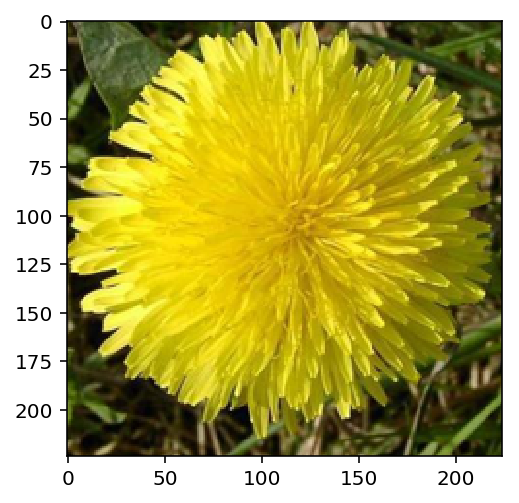

In [22]:
image_path = ('flower_data/valid/50/image_06324.jpg')
image = process_image(image_path)
imshow(image);

In [23]:
def predict(image_path, model):
    image = process_image(image_path)
    image_tensor = torch.from_numpy(image).type(torch.FloatTensor)
    image = image_tensor.unsqueeze(0)
    
    output = model(image)
    ps = torch.exp(output)
    
    top_ps, top_ls = ps.topk(5)
    top_ps = top_ps.detach().numpy().tolist()[0]
    top_ls = top_ls.detach().numpy().tolist()[0]
    
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_labels = [idx_to_class[label] for label in top_ls]
    top_flowers = [cat_to_name[idx_to_class[label]] for label in top_ls]
    
    return top_ps, top_labels, top_flowers

In [35]:
def plot(image_path, model, own_plant=False):
    
    plt.figure(figsize=(6,10))
    ax = plt.subplot(2,1,1)
    
    if own_plant:
        flower_num = image_path.split('/')[-1][:-4]
        title = flower_num
    else:
        flower_num = image_path.split('/')[-2]
        title = cat_to_name[flower_num]
    
    image = process_image(image_path)
    imshow(image, ax, title = title);
    plt.title(title)
    
    ps, ls, flowers = predict(image_path, model)
    
    plt.subplot(2,1,2)
    sns.barplot(x=ps, y=flowers, color=sns.color_palette()[0]);
    plt.show()

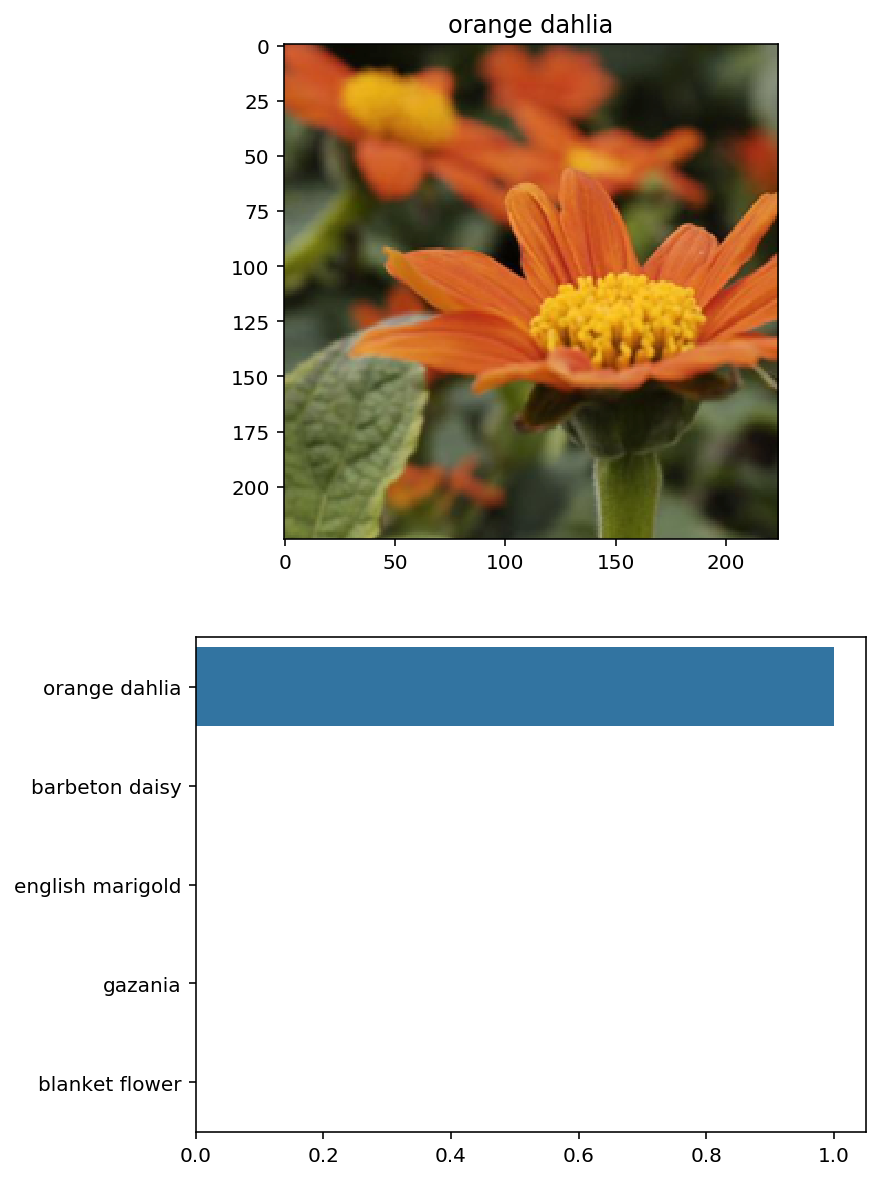

In [25]:
image_path = 'flower_data/valid/59/image_05034.jpg'
plot(image_path, model)

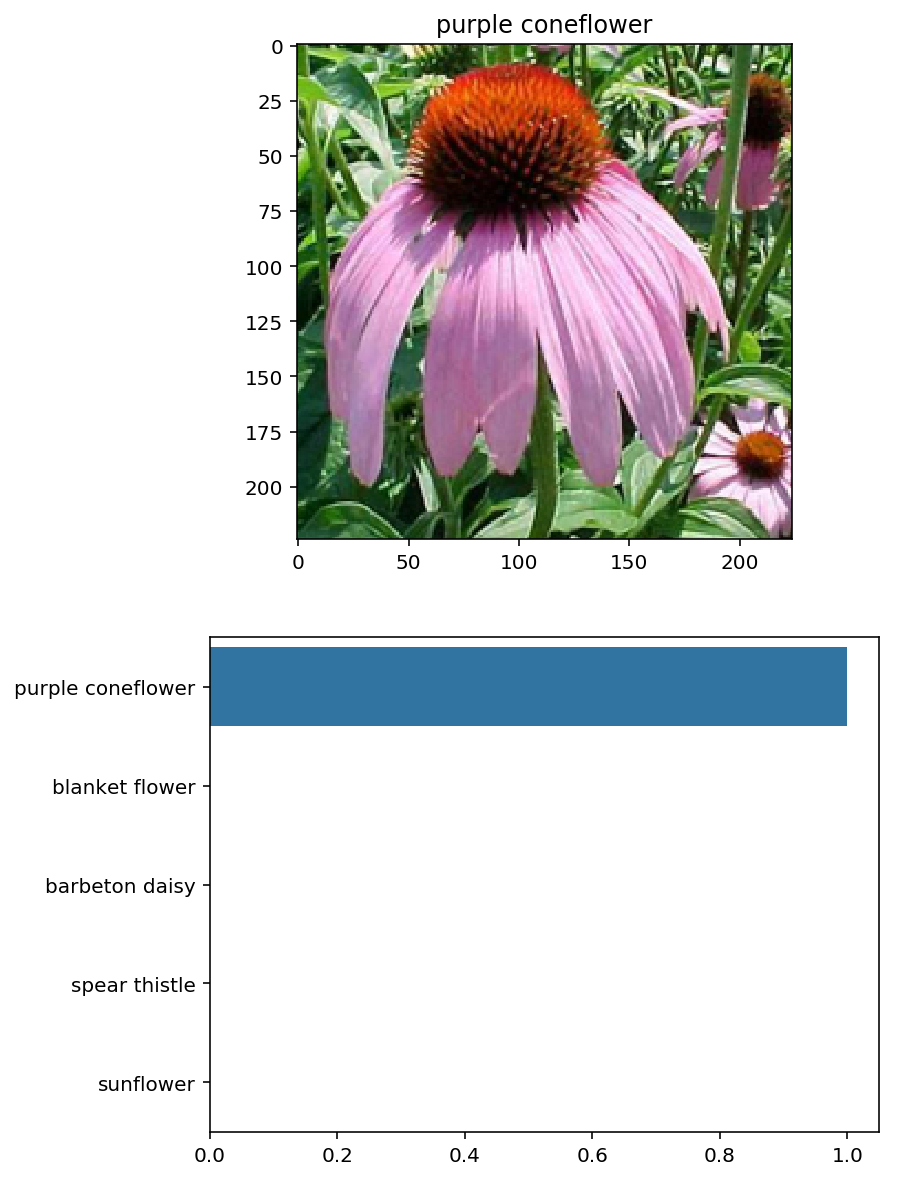

In [36]:
image_path = 'flower_data/valid/17/image_03851.jpg'
plot(image_path, model)

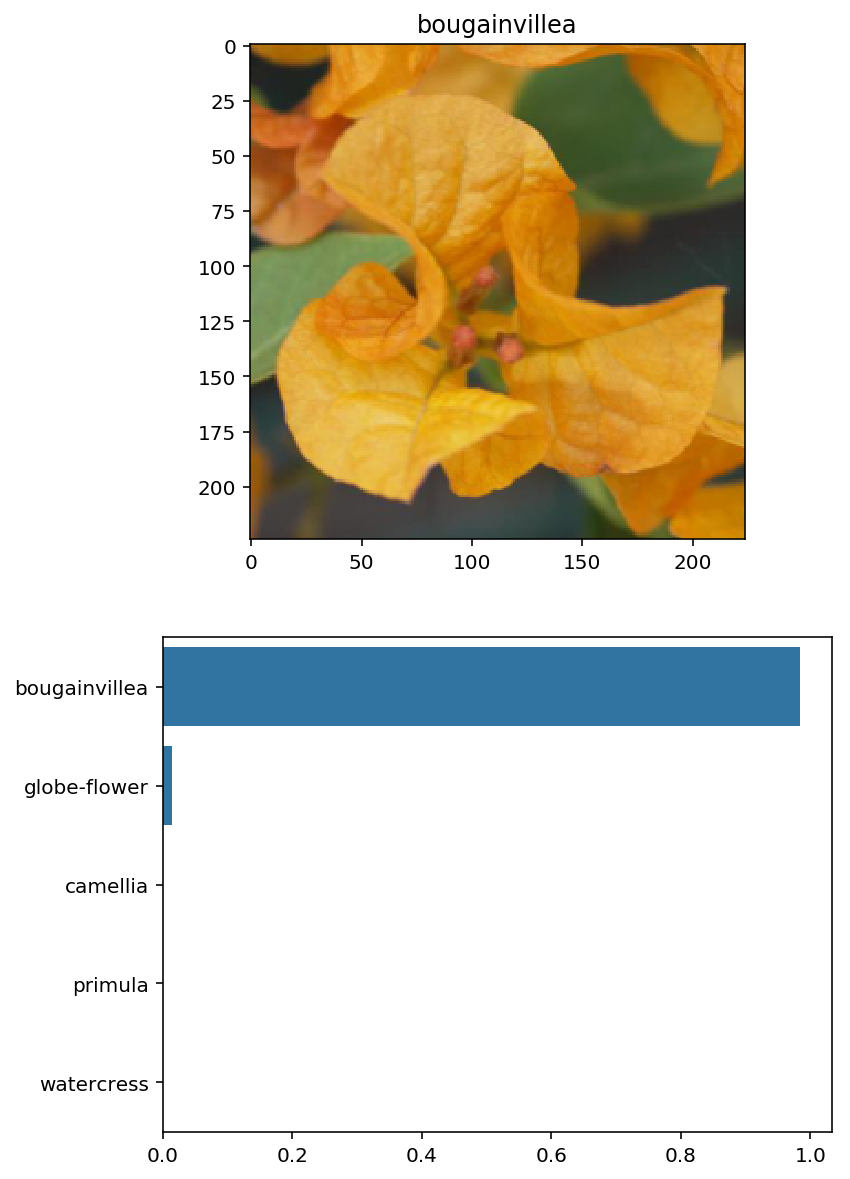

In [40]:
image_path = 'flower_data/valid/95/image_07510.jpg'
plot(image_path, model)

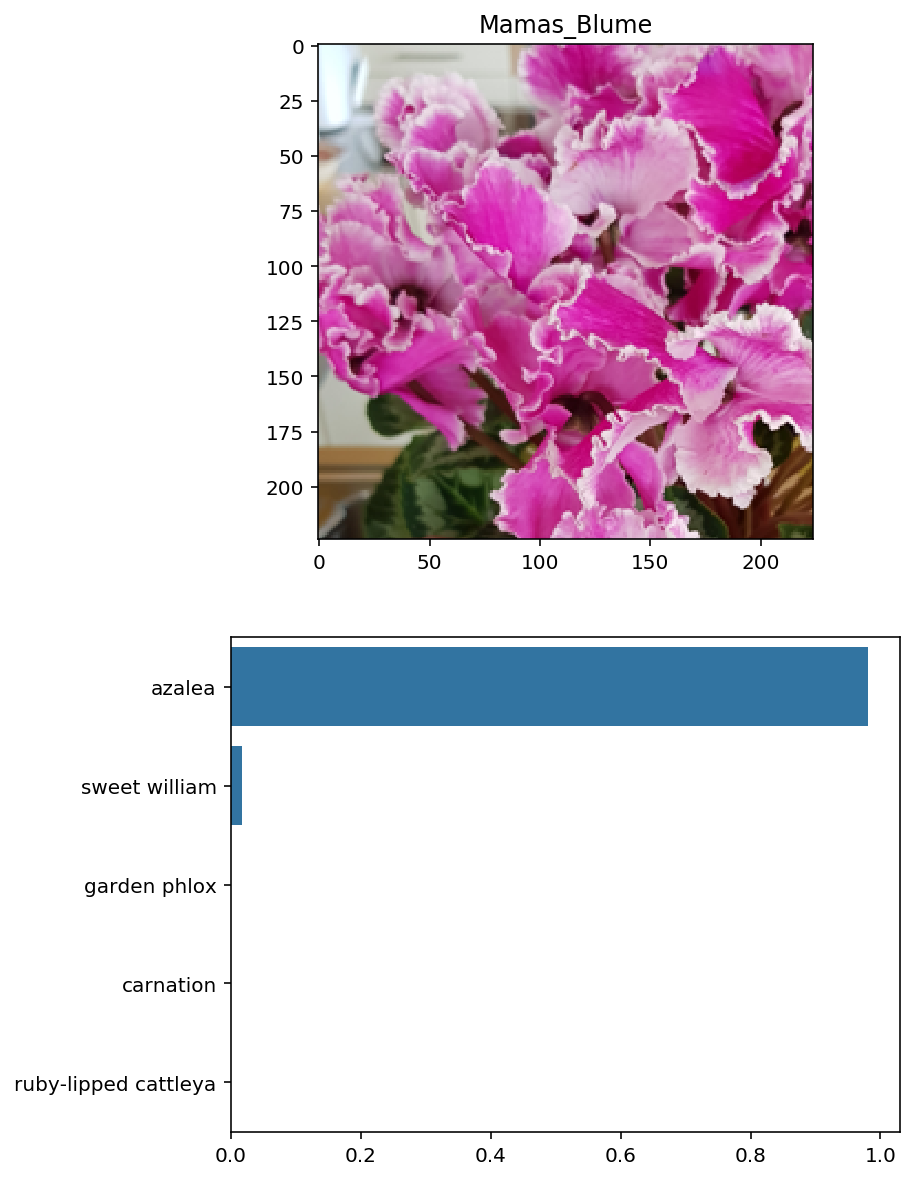

In [42]:
image_path = 'flower_data/personal/Mamas_Blume.jpg'
plot(image_path, model, own_plant=True)